## Vaccination Intervention

This notebook walks through an example of implementing vaccinations in [Epydemix](https://github.com/epistorm/epydemix). Vaccinations have been implemented by creating a new transition type which is similar to a spontaneous transition but uses a predefined vaccination schedule along with the current population of the origin compartment to dynamically calculate the transition probability. By default, vaccination schedules are set based on the [2024-2025 round of the flu scenario modeling hub](https://fluscenariomodelinghub.org/), the data for which can be found [here](https://github.com/midas-network/flu-scenario-modeling-hub_resources/blob/main/Rd5_datasets/Age_Specific_Coverage_Flu_RD1_2024_25_Sc_A_B_C_D_E_F.csv). 

First, we import the required functions

In [ ]:
from epydemix.model import EpiModel
from epydemix.visualization import plot_quantiles
from epydemix.population import load_epydemix_population
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

from flumodelingsuite.vaccinations import smh_data_to_epydemix, make_vaccination_probability_function, add_vaccination_schedule, scenario_to_epydemix

Next, we need to create an Epydemix `EpiModel` object that we wish to add vaccinations to. Crucially, the age groups in the model must be the same as the age groups in the vaccination data. Otherwise this will cause problems. The model must also include at least the source and target compartments of vaccination (e.g. "S" and "S_vaccinated") and all the compartments that are eligible to receive vaccinations.

As an example, we create a simple SIR model with a vaccinated compartment `SV`. The way we will assume that vaccinations work is that if you are vaccinated as a susceptible individual, you enter the `SV` compartment and have a lower probability of being infected. Of course you can also be vaccinated after being infected, but we assume this has no benefit in this example.

In [2]:
# define example model
population = load_epydemix_population("United_States_Massachusetts", age_group_mapping={
    "0-4": [str(i) for i in range(0, 5)],
    "5-17": [str(i) for i in range(5, 18)],
    "18-49": [str(i) for i in range(18, 50)],
    "50-64": [str(i) for i in range(50, 65)],
    "65+": [str(i) for i in range(65, 84)] + ["84+"]
})
model = EpiModel()
model.set_population(population)

# Simple SIR model with vaccination
# S: susceptible, SV: vaccinated susceptible, I: infected, R: recovered
# Vaccinated individuals are less likely to become infected by a factor of VE (vaccine efficacy)
model.add_compartments(["S", "SV", "I", "R"])
model.add_parameter(parameters_dict={"beta": 0.05, "mu": 0.1, "VE": 0.7})

model.add_transition("S", "I", params=("beta", "I"), kind="mediated")
model.add_transition("SV", "I", params=("(1 - VE) * beta", "I"), kind="mediated")
model.add_transition("I", "R", params=("mu"), kind="spontaneous")

To create a vaccine schedule from the flu scenario modeling hub scenarios, we can use the `smh_data_to_epydemix` function. The 2024/2025 data contains three scenarios (`{A_B, C_D, E_F}`) so you must specify which one to use. The original data also contains weekly coverage estimates and these are used along with the population sizes in the `model` object you pass to the function to calculate a daily vaccination schedule for each age group in a particular `location` which you must also provide. This is done by calculating the incremental number of doses that were administered by the end of week and dividing them equally among the 7 preceeding days. Crucially the `start_date` and `end_date` must be the same as those passed to the simulator. The vaccine schedule is returned as a pandas `DataFrame` and is optionally saved as a `.csv` file at `output_filepath`. 

If you wish, you can specify any custom vaccination schedule that you like as long as it follows the format of the `DataFrame` below (one column for each age group in your model with one row for the total number of vaccinations administered on each day).

In [3]:
date_start = dt.date(2024, 10, 6)
date_stop = dt.date(2025, 6, 21)

vaccination_schedule = scenario_to_epydemix_single(
    input_filepath = 'data/vaccine_scenarios_2425_cd.csv', 
    start_date=date_start, 
    end_date=date_stop,
    model=model, 
    output_filepath = None
)

vaccination_schedule['total_vax'] = vaccination_schedule[['0-4', '5-17', '18-49', '50-64', '65+']].sum(axis=1)
vaccination_schedule.head(n=30)

,dates,location,18-49,5-17,50-64,0-4,65+,total_vax
0,2024-10-06,US-AL,35917,30486,26397,13599,36103,142502
1,2024-10-06,US-AK,44303,30586,24029,10927,27441,137286
2,2024-10-06,US-AZ,39076,34409,28855,17681,37260,157281
3,2024-10-06,US-AR,39977,29989,26939,11567,26277,134749
4,2024-10-06,US-CA,45541,36793,33745,16602,36253,168934
5,2024-10-06,US-CO,55045,39475,36894,17607,42933,191954
6,2024-10-06,US-CT,47984,40039,34083,20619,34705,177430
7,2024-10-06,US-DE,35731,40159,36583,17146,39869,169488
8,2024-10-06,US-DC,76064,52682,38354,23054,41607,231761
9,2024-10-06,US-FL,28352,29880,25506,11412,28628,123778


In [ ]:
date_start = dt.date(2024, 10, 6)
date_stop = dt.date(2025, 6, 21)

vaccination_schedule = smh_data_to_epydemix(
    input_filepath = 'data/vaccine_scenarios_2425.csv', 
    start_date=date_start, 
    end_date=date_stop,
    model=model, 
    scenario="C_D",  
    output_filepath = None
)

vaccination_schedule['total_vax'] = vaccination_schedule[['0-4', '5-17', '18-49', '50-64', '65+']].sum(axis=1)
vaccination_schedule.head(n=20)

,dates,scenario,location,18-49,5-17,50-64,0-4,65+,total_vax
0,2024-10-06,A_B,US-AL,43100,36583,31676,16319,43323,171001
1,2024-10-06,A_B,US-AK,53164,36704,28835,13112,32929,164744
2,2024-10-06,A_B,US-AZ,46891,41291,34626,21217,44711,188736
3,2024-10-06,A_B,US-AR,47972,35987,32327,13881,31532,161699
4,2024-10-06,A_B,US-CA,54649,44152,40494,19922,43504,202721
5,2024-10-06,A_B,US-CO,66054,47370,44273,21129,51520,230346
6,2024-10-06,A_B,US-CT,57580,48047,40900,24742,41645,212914
7,2024-10-06,A_B,US-DE,42877,48191,43900,20575,47843,203386
8,2024-10-06,A_B,US-DC,91276,63218,46025,27665,49928,278112
9,2024-10-06,A_B,US-FL,34022,35856,30607,13695,34353,148533


Next, we need to define a vaccination probability function. This requires two arguments. First, the name of the `origin_compartment` which receives the vaccinations. This will be used to calculate the transition probabilities required to vaccinate the number of people detailed in the `vaccination schedule`. Second, a list of compartments `eligible_compartments` that are eligible to receive vaccinations. This implementation assumes the vaccines in `vaccination_schedule` are distributed amongst all those who are eligible, but only has an impact on those who were vaccinated before becoming infected (i.e. the S compartment).

In [4]:
vaccine_probability_function = make_vaccination_probability_function(
    origin_compartment="S", 
    eligible_compartments=["S", "R"]
)

Finally, we can add the `vaccination_schedule` and the `vaccine_probability_function` to the model, specifying the origin and target compartments of the new vaccination transition.

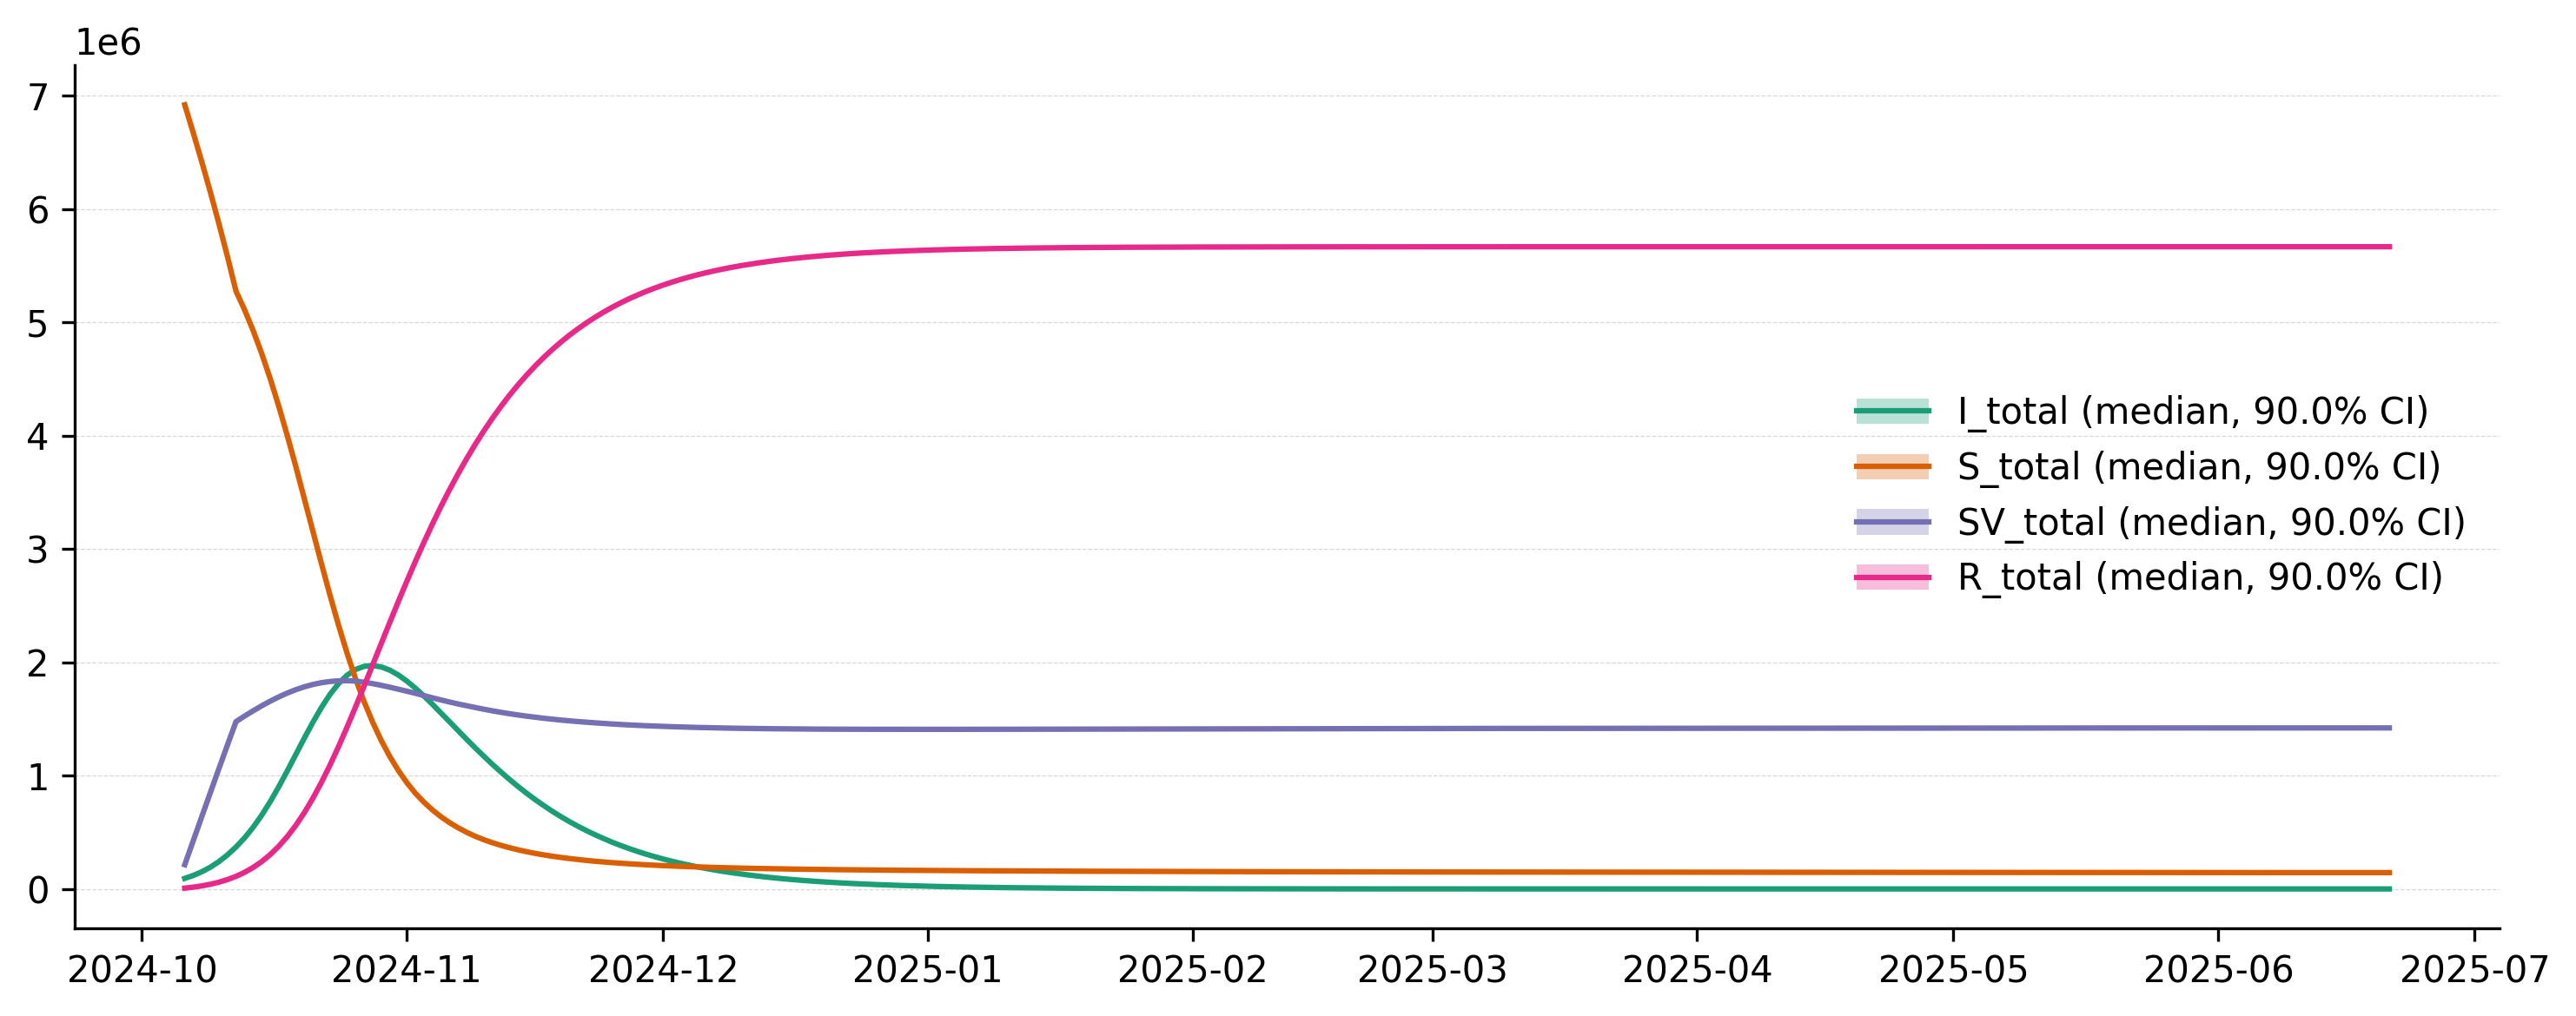

In [5]:
model = add_vaccination_schedule(
    model=model, 
    vaccine_probability_function = vaccine_probability_function,
    source_comp="S", 
    target_comp="SV", 
    vaccination_schedule = vaccination_schedule
)
# simulate 
np.random.seed(19)
model.add_parameter(parameters_dict={"beta": 0.03, "mu": 0.1, "VE": 0.8})
results = model.run_simulations(
    start_date=date_start, 
    end_date=date_stop, 
    # percentage_in_agents=10 / model.population.Nk.sum(),
    initial_conditions_dict={
        "S": (0.99 * model.population.Nk),
        "SV": (0.0 * model.population.Nk),
        "I": (0.01 * model.population.Nk),
        "R": (0.0 * model.population.Nk)},
    Nsim=25
)
df_quantiles = results.get_quantiles_compartments()
ax = plot_quantiles(df_quantiles, columns=["I_total", "S_total", "SV_total", "R_total"], legend_loc="best")

The above plot shows the familiar SIR dynamics, with the addition of the vaccinated-before-infection compartment `SV` which grows slowly as individuals from the `S` compartment are vaccinated.

To see the effect of vaccination, we can compare to a baseline scenario with no vaccinations

Text(0.5, 1.0, 'United_States_Massachusetts')

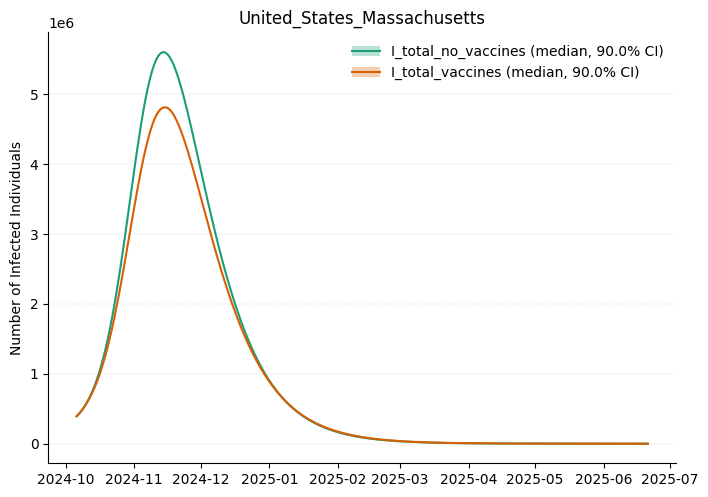

In [9]:
no_vaccination_schedule = vaccination_schedule.copy()
no_vaccination_schedule[["18-49", "5-17", "50-64", "0-4", "65+", "total_vax"]] = 0.0

# Model configurations: (name, vaccination_schedule)
configs = [
    ("no_vaccines", no_vaccination_schedule), # No intervention (baseline)
    ("vaccines", vaccination_schedule)   # With vaccinations
]

# Run simulations for all configurations
data = {}
date_start = dt.date(2024, 10, 6)
date_stop = dt.date(2025, 6, 21)

for name, vacc_sched in configs:
    model = EpiModel()
    model.set_population(population) # California population
    model.add_compartments(["S", "SV", "I", "R"])
    model.add_parameter(parameters_dict={"beta": 0.003, "mu": 0.1, "VE": 0.8})

    model.add_transition("S", "I", params=("beta", "I"), kind="mediated")
    model.add_transition("SV", "I", params=("(1 - VE) * beta", "I"), kind="mediated")
    model.add_transition("I", "R", params=("mu"), kind="spontaneous")

    vaccine_probability_function = make_vaccination_probability_function(
        origin_compartment="S", 
        eligible_compartments=["S", "R"]
    )

    model = add_vaccination_schedule(
        model=model, 
        vaccine_probability_function = vaccine_probability_function, 
        source_comp="S", 
        target_comp="SV", 
        vaccination_schedule = vacc_sched
    )
    np.random.seed(19)
    data[name] = model.run_simulations(
        start_date=date_start, 
        end_date=date_stop,
        # percentage_in_agents=15/model.population.Nk.sum(),
        initial_conditions_dict={
            "S": 0.99 * model.population.Nk.sum(),
            "SV": 0.0,
            "I": 0.01 * model.population.Nk.sum(),
            "R": 0.0},
        Nsim=25
    )

# Get quantiles and merge
dfs = {}
for name, result in data.items():
    df = result.get_quantiles_compartments()
    # Add suffix to all columns except merge keys
    for col in df.columns:
        if col not in ["date", "quantile"]:
            df = df.rename(columns={col: f"{col}_{name}"})
    dfs[name] = df

# Merge DataFrames
merged_df = dfs["no_vaccines"].merge(dfs["vaccines"], on=["date", "quantile"])

# Plot results
fig, ax = plt.subplots(figsize=(7, 5))
plot_quantiles(
    merged_df, 
    columns=["I_total_no_vaccines", "I_total_vaccines"], 
    legend_loc="upper right", 
    ax=ax
)
ax.set_ylabel("Number of Infected Individuals")
ax.set_title(model.population.name)

As expected, vaccinations reduce the severity of the epidemic. The trajectory with vaccinations implemented has a lower peak relative to the scenario where no vaccines are administered.

Finally we can look at how faithfully the simulation with vaccination recreates the vaccination schedule data that we used to parameterize it. Here, there are three quantities we want to track

1. **Raw daily doses**: the daily vaccine doses specified in the vaccine schedule data
2. **S_to_Sv transitions**: this is the number of vaccines that were actually administered in the model
3. **Effective doses**: this is the raw daily doses but rescaled by the fraction of eligible individuals in the S compartment. This accounts for susceptible depletion because if there are no susceptible individuals left, the model cannot administer any doses to them!

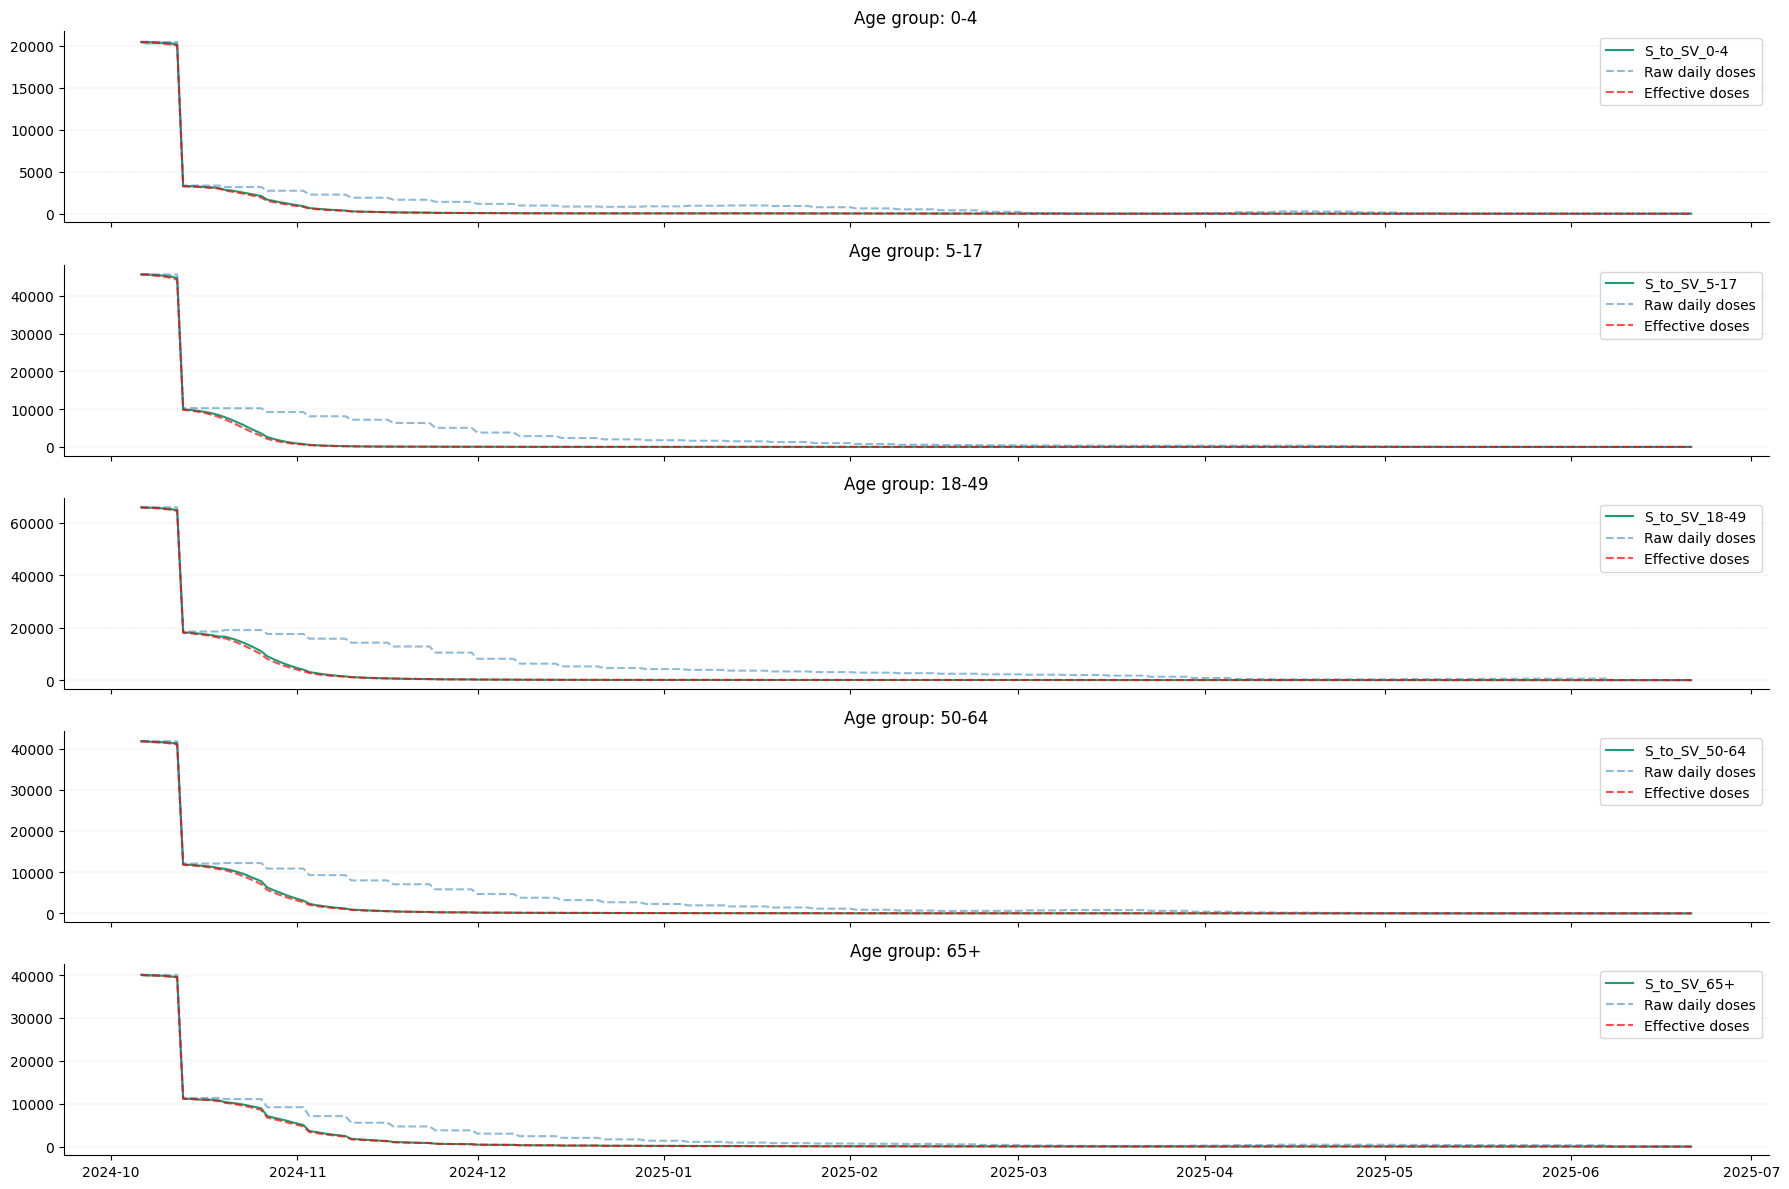

In [8]:
df_quantiles_trans = results.get_quantiles_transitions()
df_comp = results.get_quantiles_compartments()
df_median = df_comp.loc[df_comp["quantile"] == 0.5]

fig, axes = plt.subplots(5, 1, figsize=(18, 12), sharex=True)

age_groups_vax = ['0-4', '5-17', '18-49', '50-64', '65+']
age_groups_model = ['0-4', '5-17', '18-49', '50-64', '65+']

vaccination_schedule_filt = vaccination_schedule.query("location == 'US-MA'").copy()

for idx, (vax_age, model_age) in enumerate(zip(age_groups_vax, age_groups_model)):
    # compute effective doses
    S = df_median[f"S_{model_age}"].values
    R = df_median[f"R_{model_age}"].values
    eligible = S + R
    fraction_S = np.where(eligible > 0, S / eligible, 0)
    effective_doses = vaccination_schedule_filt[vax_age].values * fraction_S
    vaccination_schedule_filt[f"effective_doses_{vax_age}"] = effective_doses

    ax = plot_quantiles(df_quantiles_trans, columns=[f"S_to_SV_{model_age}"], legend_loc="center right", ax=axes[idx])
    ax.plot(vaccination_schedule_filt["dates"], vaccination_schedule_filt[vax_age], linestyle="--", alpha=0.5, label="Raw daily doses")
    ax.plot(vaccination_schedule_filt["dates"], vaccination_schedule_filt[f"effective_doses_{vax_age}"], linestyle="--", alpha=0.7, color="r", label="Effective doses")
    ax.set_title(f"Age group: {vax_age}")
    ax.legend()

plt.tight_layout()
plt.show()


At the beginning of the epidemic, the average `S_to_SV` transitions in the model **closely recapitulate** both the raw daily doses and the effective doses across all age groups. As the epidemic progresses, the raw daily doses and effective doses **diverge because the more and more susceptible individuals have been infected**. The `S_to_SV` transitions continues to follow the trajectory of the effective doses, which is expected because the effective doses represents the fraction of vaccine eligible individuals in the S compartment. Essentially, what is happening is **the majority of vaccines are being administered to people in the R compartment** because they make up a bigger fraction of the eligible population as the epidemic progresses, **but these vaccinations don't yield any benefit in this model** since those individuals have already been infected.